# Intro

I wasn't quite ready to return to reality last week so I skipped ahead a few steps in the project to something that would allow me to read papers and noodle around in Julia without dealing with, like, actual data and stuff.

Up till now I have been using a Dirichlet prior over category weights, which is the conventional choice. However, we would like to at some point incorporate various covariates into the model so as to determine so as to learn how demographic, environmental, and genetic factors impact the occurrence different patterns of behavior. A simple and flexible means of incorporating multiple arbitrary covariates is to simply staple a linear model layer on top of the model, such that the covariates and regression coefficients determine the relative probabilities of an observation belonging to each category.

However, putting a linear model on top of a Dirichlet distribution has a few awkward properties. First, it breaks conditional conjugacy, which makes several popular and relatively straightforward methods of inference, such as Gibbs sampling and variational inference, impossible. Second, it's not super intuitive to me how to set this up while maintaining the sparsity bias we need in order to squeeze unused and unnecessary categories down to having 0 weight.

An alternative is to replace the Dirichlet prior over category weights with a prior that uses latent normally distributed random variables to represent category weights, then uses some tranformation to convert them into probabilities. There are two such priors that have represntations that allow full conjugacy: the *normal probit* and *normal logistic* models. So that solves our conjugacy problem -- but can we get sparsity from them? And how do they compare to the Dirichlet that we know and love? That is the question for today!

# Normal-Probit

First let's look at the normal probit model. I've never ever seen this used in Machine Learning but it is very popular in economics because it can be interpreted as a random utility choice model. The idea is this: each of $D$ categories has some latent weight $\eta_d$, which we will treat as normally distributed (though it could be anything, technically):

$\eta_d \sim \textrm{N}(0,\sigma^2_\eta)$ $\forall$ $d \in 1,...,D$

Then on each trial $i$, normally distributed noise is added to those weights, and the category with the largest resulting net weight $w$ gets "chosen", as if it the weight were utility.

$w_{i,d} \sim \textrm{N}(\eta_d,\sigma^2_w)$ $\forall$ $d \in 1,...,D$

$y_i = \max(w_{i,1},...,w_{i,D})$

Note that the category weights are never explicitly represented in terms of probabilities here, so I approximate them by Monte-Carlo sampling.

Intuitively, the expected level of sparsity here is given by the ratio $\sigma^2_w/\sigma^2_\eta$. When the per-trial noise $\sigma^2_w$ is relatively small, the differences between $\eta_d$ and $w_d$ will be small and so the categories with the larger $\eta$s will usually also have the largest $w_d$s. However, if $\sigma^2_w$ is relatively large, any category has a shot at being chosen on any given trial. In practice, we can fix $\sigma_\eta$ at $1$.

Let's draw some sample category weights from this model at various dimensionalities $D$ and per-observation noises $\sigma^2_w$.

In [2]:
using Distributions, Gadfly, DataFrames
include("/home/seth/code/sparse_normal_categorical/rnormcat.jl");

In [3]:
n = 2500;                  #number of samples to draw
d = [5,10,20,40,80,160];   #number of categories D
se = [0.2,.4,.6,.8];       #standard deviations of the latent generative process
nd = length(d);
nse = length(se);

In [4]:
dtnp = DataFrame(ntrp_mean=zeros(nd*nse),ntrp_sd=zeros(nd*nse),sprs_mean=zeros(nd*nse),sprs_sd=zeros(nd*nse),d=zeros(nd*nse),se=zeros(nd*nse));

l = 0;
for i in 1:nd
    for j in 1:nse
        l += 1;
        x = rnormalprobit(n,d[i],se[j]);                         #sample from model
        
        ent = [Float64(entropy(x[:,k])) for k in 1:n];           #entropy
        dtnp[:ntrp_mean][l] = mean(ent);
        dtnp[:ntrp_sd][l] = std(ent);
        
        sparse = [Float64(mean(x[:,k].<0.0001)) for k in 1:n];   #sparsity
        dtnp[:sprs_mean][l] = mean(sparse);
        dtnp[:sprs_sd][l] = std(sparse);
        
        dtnp[:d][l] = d[i]; dtnp[:se][l] = se[j];
    end
end

So, how to go about comparing this distribution to the Dirichlet? It's hard to visualize 5 dimensions, let alone 160. But maybe we can just look at summary statistics of the relevant features.

First, of course, is sparsity, which I'll measure simply as the number of categories with weight below some very small arbitrary threshold (they should never be actually 0). However, we'd also probably not want the distribution of weights in the non-empty categories to be too lopsided -- that is, only having sparsity at the cost of having a super strong bias towards only a single large category and then a bunch of little ones. I'll measure that via entropy. Obviously there's going to be a tradeoff between the two, but how much compared to the dirichlet?

Below I sample and compute those stastics for the Dirichlet using the standard default parameter $1/D$, and plot the comparison.

In [5]:
dtd = DataFrame(ntrp_mean=zeros(nd),ntrp_sd=zeros(nd),sprs_mean=zeros(nd),sprs_sd=zeros(nd),d=d)
for i in 1:nd
    x = rand(Dirichlet(d[i],1/d[i]),n);
    
    ent = [Float64(entropy(x[:,k])) for k in 1:n];
    dtd[:ntrp_mean][i] = mean(ent);
    dtd[:ntrp_sd][i] = std(ent);
        
    sparse = [Float64(mean(x[:,k].<0.0001)) for k in 1:n];
    dtd[:sprs_mean][i] = mean(sparse);
    dtd[:sprs_sd][i] = std(sparse);
end

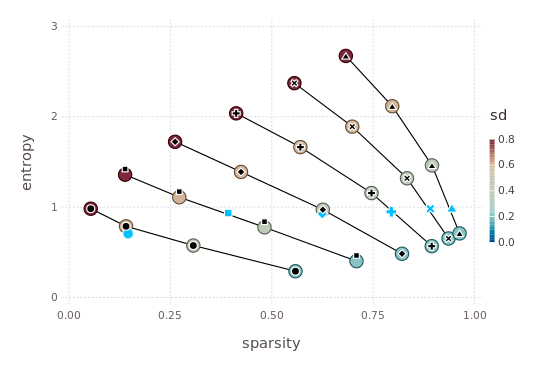

In [80]:
plot(layer(x=dtnp[:sprs_mean],y=dtnp[:ntrp_mean],shape=dtnp[:d],group=dtnp[:d],Geom.point,Geom.line,Theme(default_point_size=3pt,default_color=colorant"black")),
layer(x=dtd[:sprs_mean],y=dtd[:ntrp_mean],shape=dtd[:d],Geom.point,Theme(default_point_size=4pt)),
layer(x=dtnp[:sprs_mean],y=dtnp[:ntrp_mean],color=dtnp[:se],Geom.point,Theme(default_point_size=5pt)),
Guide.xlabel("sparsity"),Guide.ylabel("entropy"),Guide.colorkey("sd"))

Okay so first of all I apologize for how badly this plot sucks. There is a bug in this plotting package that messes up colors if you try to make points vary by both color and shape so I had to resort to this weird backgrounding thing.

Here's what the plot means: the bright blue points are the dirichlet and the black-in-colored-cirlces are the normal-probit. The different shapes are different dimensionalities $D$, increasing as you go up and right (circle is 5, square is 10, etc). The colors of the surrounding circles represent $\sigma^2_w$.

As expected, as $\sigma^2_w$ goes down expected sparsity goes up and expected entropy goes down, while both sparsity and entropy increase with $D$. What's interesting is that for every value of $D$, the dirichlet points lie directly between two of the normal-probit points. Getting to the point, this suggests that *at any dimensionality, there is some value of $\sigma^2_w$ such that the normal-probit has a similar balance between entropy and sparsity as the dirichlet*.

# Normal-Logit

This one is a straightforward generalization of logistic regression. You just sample some weights $\eta$ from a normal distribution and push them through a softmax.

$\eta_d \sim \textrm{N}(0,\sigma^2)$ $\forall$ $d \in 1,...,D$

$\pi_d = \exp(\eta_d) / \sum_{i=1}^{D}(\exp(\eta_d))$ $\forall$ $d \in 1,...,D$

$y_i \sim \textrm{Multinomial}(\mathbf{pi})$

Here $\sigma^2$ acts as the (inverse) temperature parameter for the softmax. The higher it is, the more concentrated the probabilities are on the largest of the $\eta$s. Because of this, I was concerned that this distribution cannot achieve sparsity without degenerating into extremely low entropy distributions. Again, let's test this by drawing some samples and comparing to the Dirichlet.

In [13]:
dtnl = DataFrame(ntrp_mean=zeros(nd*nse),ntrp_sd=zeros(nd*nse),sprs_mean=zeros(nd*nse),sprs_sd=zeros(nd*nse),d=zeros(nd*nse),se=zeros(nd*nse));

l = 0;
for i in 1:nd
    for j in 1:nse
        l += 1;
        x = rnormallogit(n,d[i],se[j]*10);
        
        ent = [Float64(entropy(x[:,k])) for k in 1:n];
        dtnl[:ntrp_mean][l] = mean(ent);
        dtnl[:ntrp_sd][l] = std(ent);
        
        sparse = [Float64(mean(x[:,k].<0.0001)) for k in 1:n];
        dtnl[:sprs_mean][l] = mean(sparse);
        dtnl[:sprs_sd][l] = std(sparse);
        
        dtnl[:d][l] = d[i]; dtnl[:se][l] = se[j]*5;
    end
end

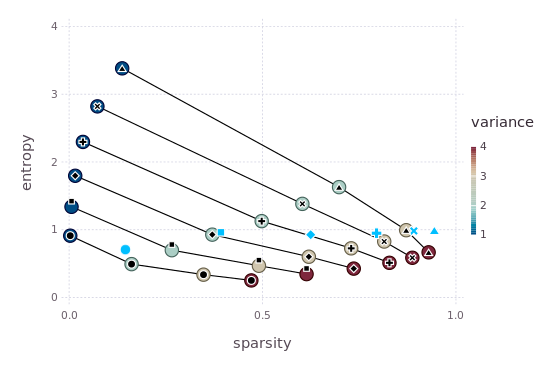

In [79]:
plot(layer(x=dtnl[:sprs_mean],y=dtnl[:ntrp_mean],shape=dtnl[:d],group=dtnl[:d],Geom.point,Geom.line,Theme(default_point_size=3pt,default_color=colorant"black")),
layer(x=dtd[:sprs_mean],y=dtd[:ntrp_mean],shape=dtd[:d],Geom.point,Theme(default_point_size=4pt)),
layer(x=dtnl[:sprs_mean],y=dtnl[:ntrp_mean],color=dtnl[:se],Geom.point,Theme(default_point_size=5pt)),
Guide.xlabel("sparsity"),Guide.ylabel("entropy"),Guide.colorkey("sd"))

This is read the same way as the previous graph.

Notice that all the blue, dirichlet points lie waaay of the lines corresponding to the normal-logits of the same dimensionality. It does seem like at most if not all dimensionalities $D$, the normal-logit is only capable of hitting similar levels of sparsity as the Dirichlet if it also has much lower entropy.

In other words, my fears were correct! Yay?

# Tentative conclusions and... the future!

Based on this rather ad-hoc analysis, it does seem like the normal-probit is a better choice in that it may not impose such a strong prior on the relative weights of "non-empty" categories. Or... I could be misinterpreting how entropy is actually manifesting here. It would take more digging to say anything particularly definitive.

The other issue at hand is how to preserve sparsity once we add predictors. One idea is put a restrictive prior (cauchy?) on the variance of the regression coefficients such that their impact is usually relatively small -- that is, a predictor should be very unlikely to boost a category from "empty" to "non-empty". Anyway, that's work for another day.

Finally, I should note that it probably won't, in the end, be computationally feasible to incorporate much of the genetic data directly into the behavioral model. However, it would be nice to be able to directly build into the model individual differences, demographics, and maybe even relatedness. We could then take the output of that model and plug that into SNP analyses. This is a first step towards doing that.